<div style="text-align:center">
    <h1>
        Continuous state spaces
    </h1>
</div>

<br><br>

<div style="text-align:center">
    In this notebook we will learn how to adapt tabular methods to continuous state spaces. We will do it with two methods: 
    state aggregation and tile coding.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 7 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

In [ ]:
#tqdm function will show us the progress bar when we execute the service algo that will tell us how many iter in the main loop
#we have already executed and how many are left

## Implement state aggregation

<br><br>

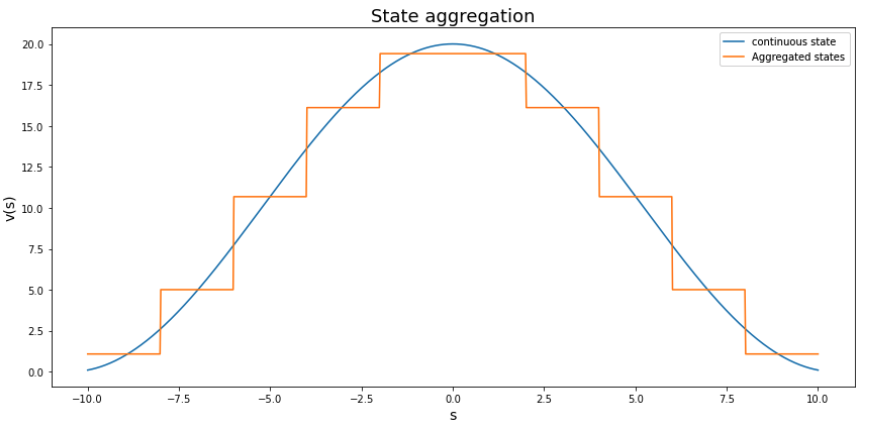

### Create the environment

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env) # to make sure that every time we execute this library we obtain the same result

In [3]:
env.reset() # observation - first value repres the position and second repres the velocity

array([-0.52517134,  0.        ], dtype=float32)

D:\Users\apytl\AppData\Anaconda3\envs\bmrl\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


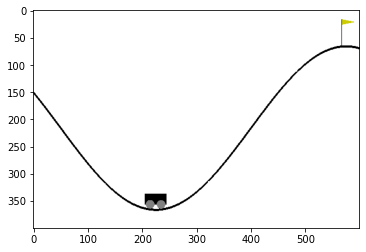

In [4]:
#display
frame = env.render(mode='rgb_array')
plt.imshow(frame)

In [ ]:
#the task is to give enough momenum for the car to reach the flag. In this case, we only have 3 actions: move it back/left, 
#move it forward/right or not moving it at all. The task is continuous as its states (position and speed) have continuous values
#To apply SARSA, we need to aggregate the continuous states into discrete states

### Create the state aggregation wrapper

In [ ]:
""" The strategy that we will follow consists in creating an object that will wrap the environment.
And modify the states that the environment generates, then every time that we interact with the
environment and it generates a state, the object that wraps the environment will modify
that state so that we can work with it."""

In [5]:
class StateAggregationEnv(gym.ObservationWrapper): #ie this class inherites a class in the gym library called ObservationWrapper
    def __init__(self, env, bins, low, high):
        #low =[-1.2, -.07], high = [0.6, 0.07], bins = [20, 20] ie 20 aggregated states
        super().__init__(env) # call init from the superClass and it'll execute the init from the ObservationWrapper
        self.buckets = [np.linspace(l, h, b-1) for l, h, b, in zip(low, high, bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()) #ie we want 20 possible values for the position of
        #of the car and 20 other for the velocity...for a total of 400 (20x20) possible state. Like in 5x5 maze
        
    #need to modify the state that the env generates, then we'll move from continuous to aggreate states. 
    #to do this we need to override the observation space method from ObservationWrapper class
    
    def observation(self, state):
        # eg. [-1.2, 0.] -> (4, 3) ie pos=4, vel=3 just like (row, col) for a case of Maze
        indices = tuple(np.digitize(cont, buck) for cont, buck in zip(state, self.buckets))
        #And will pass each pair of these two elements to the digitize function so that it tell us in which range
        #each of the continuous values of this date falls and the result will store it in a tuple called indicesthat will take this form.
        
        return indices
        

In [7]:
#test
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

In [8]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

In [ ]:
#we can now use the tabular method to solve this task

### Compare the original environment to the one with aggregated states

In [11]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [12 13]


In [10]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.52654195 -0.0021926 ]


### Create the $Q(s,a)$ value table

In [13]:
 action_values = np.zeros((20,20, 3)) # 3 action

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [14]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [15]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [16]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:09<00:00, 80.07it/s]


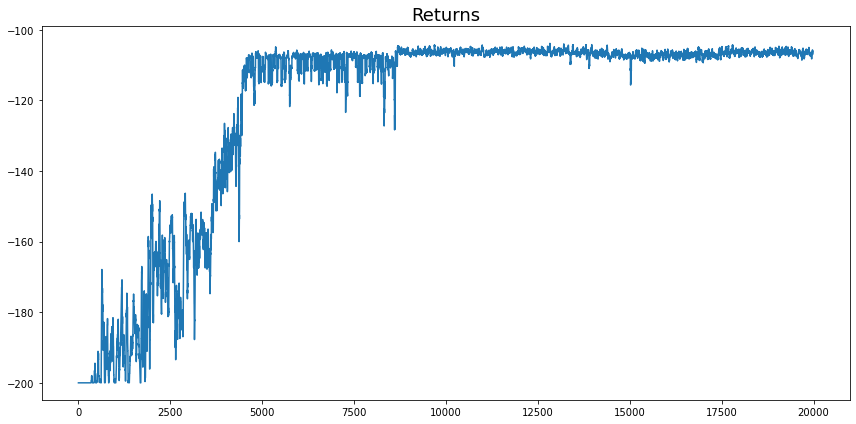

In [17]:
plot_stats(stats)

In [ ]:
#Here we have all the retruns throught out the learning process. At any moment in time when the agent does not reach the goal, 
#the reward is -1. 

""" As you can see, the agent is getting the rewards of negative 200 and slowly as it explores and learns how to reach the goal.
And as it improves the estimate of the Kubelik table, it starts to obtain better results.And starting at around Episode 8000, 
it's capable of finding the exit efficiently."""

### Plot the learned policy: $\pi(s)$

In [20]:
action_values[:2][:2]

array([[[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0

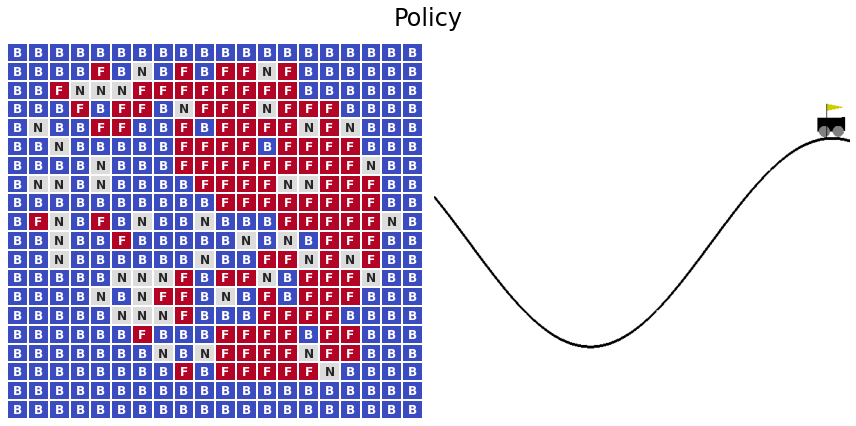

In [21]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

In [ ]:
""" As you cna see the policy is represented by 20x20 grid. X-axis repres the position and Y-axis the vel of the car
and there is an optimal action for each of these states."""

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

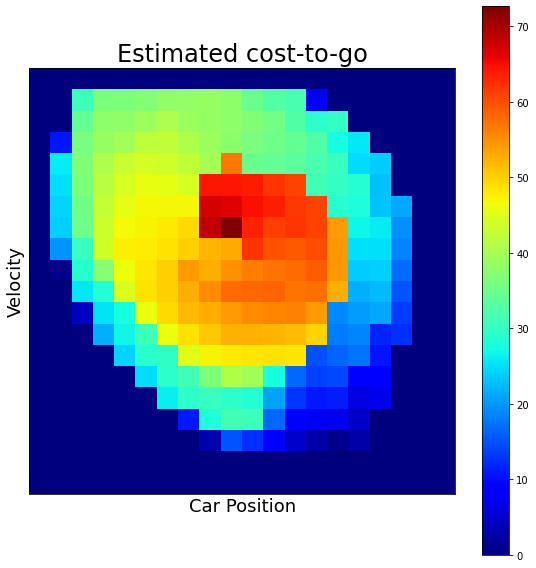

In [22]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

In [ ]:
""" this is the cost to go function or the cost to reach the goal. This graph tell us the approxmate cost of getting to 
the goal in terms of the reward. Each square is a comb of pos and vel. The cost is -max_Q(s, a|theta) From the initail 
state in black, id the one with the highest cost to go, it has a max q-value of 70. Therefore its cost to go to the goal 
is around +70. 
As you can see, the cost to go function tells us pretty much the same as the policy starting at the initial state, we can get to 
the goal by advancing a little bit, then moving back to taking place and then pushing the car up the slope to reach the goal.
Finally, let's test the policy. """


### Test the resulting policy

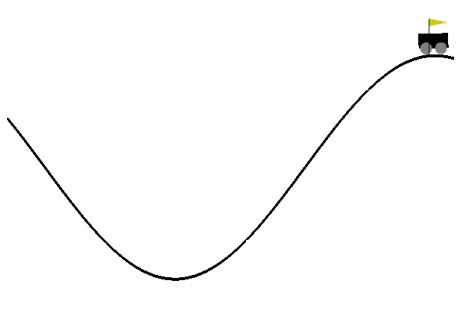

In [23]:
test_agent(saenv, policy, 2)

<br><br><br><br>

## Implement Tile Coding

<br><br>

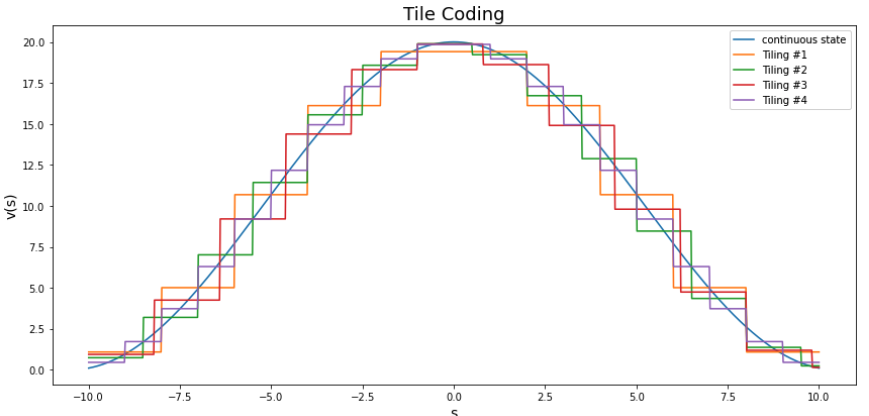

### Create the environment

In [24]:
env =  gym.make('MountainCar-v0')
seed_everything(env) # to make sure our results are reproducible

### Create the Tile Coding wrapper

In [29]:
class TileCodingEnv(gym.ObservationWrapper):
    
    #initialise the class
    def __init__(self, env, bins, low, high, n): #n = # of states aggregation we want to create
        super().__init__(env)
        self.tilings = self._create_tilings(bins, low, high, n)
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * n)
    
    
    
    #Override the observation
    def observation(self, state):
        #we gonna have a list of tuples [(5, 4),(5, 3), (4, 4), (5, 4)] for n=4
        indices = []
        for t in self.tilings:
            tilings_indices = tuple(np.digitize(i,b) for i, b in zip(state, t))
            indices.append(tilings_indices)
        return indices
    
    
    #create tilings
    def _create_tilings(self, bins, low, high, n):
        displacement_vector = np.arange(1, 2*len(bins), 2) #[1, 3]
        tilings = []
        
        for i in range(1, n+1):
            low_i = low - random.random() * .2 * low  #move horizontaly the state aggregation 
            high_i = high + random.random() * .2 * high
            segment_sizes = (high_i - low_i) / bins
            displacements = displacement_vector * i % n #displace eacg dim by i%n
            displacements =  displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(l, h, b-1) for l, h, b, in zip(low_i, high_i, bins)]
            tilings.append(buckets_i)
        
        return tilings
            

In [30]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

### Compare the original environment to the one with aggregated states

In [31]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: [(6, 8), (5, 8), (6, 9), (6, 8)]


In [32]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.5031323  0.       ]


### Create the $Q(s,a)$ value table

In [37]:
action_values = np.zeros((4, 20, 20, 3)) #4= # of state aggregation

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [38]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
            
        #[[1, 2, 3], [4, 5, 6]] -> [2.5, 3.5, 4.5]   
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment

In [39]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [40]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:34<00:00, 34.82it/s]


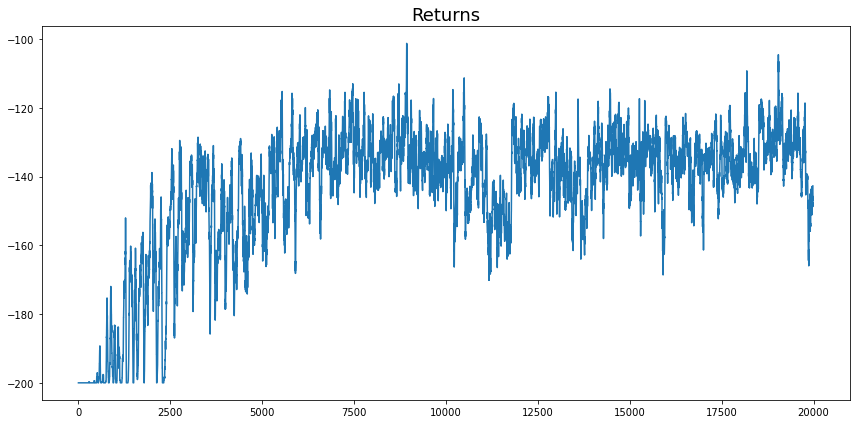

In [41]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

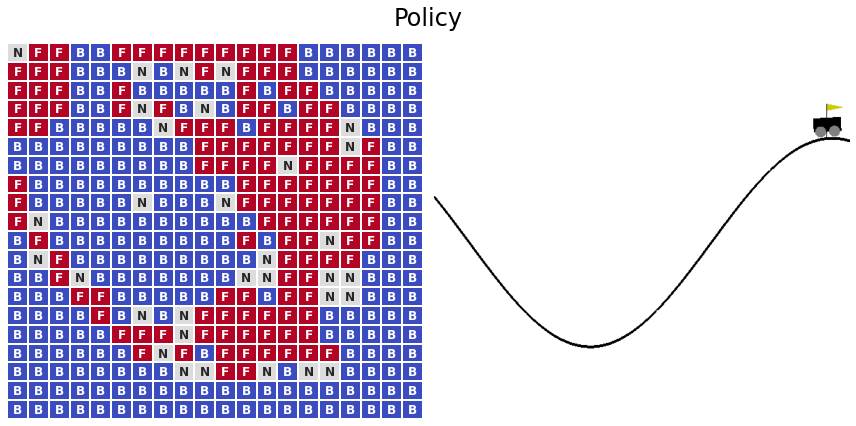

In [42]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

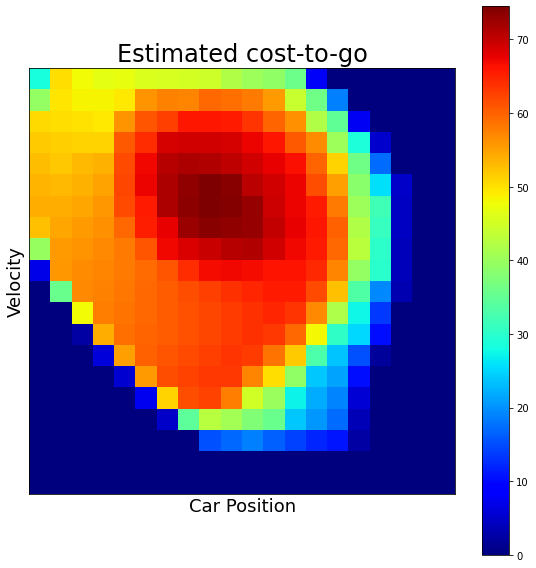

In [43]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

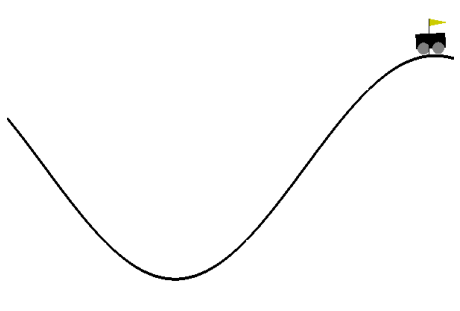

In [44]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)